# 04 – Experiments: Model Comparison & Hyperparameter Sensitivity

Ziel: Systematischer Vergleich von (a) klassischer Baseline und (b) Transformer-Modellen
unter Variation ausgewählter Hyperparameter (Epochen, Sequenzlänge, Modellgröße).
Gemessen werden Performance (Accuracy/Macro-F1) und Effizienz (Trainingszeit).


In [1]:
from pathlib import Path
import time
import json
import numpy as np
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
DATA_CSV = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)

EXP_DIR = RESULTS_DIR / "experiments_hparams"
EXP_DIR.mkdir(exist_ok=True)

DATA_CSV, EXP_DIR


(WindowsPath('c:/CAS/cas-ml-document-classification/data/processed/bbc_news.csv'),
 WindowsPath('c:/CAS/cas-ml-document-classification/results/experiments_hparams'))

Daten laden und Split (80/10/10)

**Hinweis:** Wir verwenden einen 80/10/10 Split (Train/Val/Test), um Hyperparameter auf dem 
Validation-Set zu vergleichen und das Test-Set nur für die finale Evaluation zu nutzen.
Dies verhindert Information Leakage bei der Modellwahl.

In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(DATA_CSV)

labels_sorted = sorted(df["label"].unique())
label2id = {l:i for i,l in enumerate(labels_sorted)}
id2label = {i:l for l,i in label2id.items()}

X = df["text"].astype(str).values
y = df["label"].map(label2id).values

# 80/10/10 Split: Train / Validation / Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.111,  # 0.111 von 90% ≈ 10% vom Gesamt
    random_state=42,
    stratify=y_temp
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"Labels: {labels_sorted}")

Train: 1779, Val: 223, Test: 223
Labels: ['business', 'entertainment', 'politics', 'sport', 'tech']


Baseline einmal rechnen: TF-IDF + LogReg

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words="english")),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
])

t0 = time.time()
baseline.fit(X_train, y_train)
train_time = time.time() - t0

# Validation Predictions
pred_val = baseline.predict(X_val)
val_acc = accuracy_score(y_val, pred_val)
val_f1 = f1_score(y_val, pred_val, average="macro")

# Test Predictions
pred_test = baseline.predict(X_test)
test_acc = accuracy_score(y_test, pred_test)
test_f1 = f1_score(y_test, pred_test, average="macro")

baseline_result = {
    "run_name": "baseline_logreg",
    "model": "tfidf+logreg",
    "epochs": None,
    "max_length": None,
    "learning_rate": None,
    "batch_size": None,
    "train_time_sec": round(train_time, 2),
    "val_accuracy": round(float(val_acc), 4),
    "val_macro_f1": round(float(val_f1), 4),
    "test_accuracy": round(float(test_acc), 4),
    "test_macro_f1": round(float(test_f1), 4),
}
baseline_result

{'run_name': 'baseline_logreg',
 'model': 'tfidf+logreg',
 'epochs': None,
 'max_length': None,
 'learning_rate': None,
 'batch_size': None,
 'train_time_sec': 2.22,
 'val_accuracy': 0.9821,
 'val_macro_f1': 0.9817,
 'test_accuracy': 0.991,
 'test_macro_f1': 0.9912}

Helper: Metrics Function

In [4]:
from sklearn.metrics import precision_score, recall_score

def compute_metrics_np(y_true, y_pred):
    return {
        "test_accuracy": round(float(accuracy_score(y_true, y_pred)), 4),
        "test_macro_f1": round(float(f1_score(y_true, y_pred, average="macro")), 4),
        "test_macro_precision": round(float(precision_score(y_true, y_pred, average="macro", zero_division=0)), 4),
        "test_macro_recall": round(float(recall_score(y_true, y_pred, average="macro", zero_division=0)), 4),
    }


BERT Training Runner – einmal sauber kapseln (CUDA wichtig)

In [5]:
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [6]:
def run_transformer_experiment(
    run_name: str,
    model_name: str,
    max_length: int = 128,
    epochs: int = 3,
    learning_rate: float = 2e-5,
    batch_size: int = 16,
    seed: int = 42
):
    # Dataset -> HF Dataset
    train_ds = Dataset.from_dict({"text": list(X_train), "label": list(y_train)})
    val_ds   = Dataset.from_dict({"text": list(X_val),   "label": list(y_val)})
    test_ds  = Dataset.from_dict({"text": list(X_test),  "label": list(y_test)})

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(batch):
        return tokenizer(
            batch["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length
        )

    train_tok = train_ds.map(tokenize, batched=True)
    val_tok   = val_ds.map(tokenize, batched=True)
    test_tok  = test_ds.map(tokenize, batched=True)

    # Format für PyTorch
    train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    val_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(labels_sorted),
        id2label=id2label,
        label2id=label2id
    ).to(device)

    args = TrainingArguments(
        output_dir=str(EXP_DIR / run_name),
        num_train_epochs=epochs,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy="epoch",
        save_strategy="no",
        logging_strategy="epoch",
        seed=seed,
        report_to="none"
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        return compute_metrics_np(labels, preds)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=val_tok,  # Validation für Training-Monitoring
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    t0 = time.time()
    trainer.train()
    train_time = time.time() - t0

    # Validation Metrics (für Hyperparameter-Vergleich)
    val_res = trainer.evaluate(val_tok)
    
    # Test Metrics (finale Evaluation)
    test_res = trainer.evaluate(test_tok)
    
    result = {
        "run_name": run_name,
        "model": model_name,
        "epochs": epochs,
        "max_length": max_length,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "train_time_sec": round(train_time, 2),
        # Validation Metrics (für Modellwahl)
        "val_accuracy": round(float(val_res.get("eval_test_accuracy", val_res.get("eval_accuracy", np.nan))), 4),
        "val_macro_f1": round(float(val_res.get("eval_test_macro_f1", val_res.get("eval_macro_f1", np.nan))), 4),
        # Test Metrics (finale Evaluation)
        "test_accuracy": round(float(test_res.get("eval_test_accuracy", test_res.get("eval_accuracy", np.nan))), 4),
        "test_macro_f1": round(float(test_res.get("eval_test_macro_f1", test_res.get("eval_macro_f1", np.nan))), 4),
        "test_macro_precision": round(float(test_res.get("eval_test_macro_precision", test_res.get("eval_macro_precision", np.nan))), 4),
        "test_macro_recall": round(float(test_res.get("eval_test_macro_recall", test_res.get("eval_macro_recall", np.nan))), 4),
    }
    return result

Experiment-Plan definieren

In [7]:
experiment_plan = [
    # === BERT-base: 2x2 Grid (epochs × max_length) ===
    {"run_name": "bert_base_e2_len128", "model_name": "bert-base-uncased", "epochs": 2, "max_length": 128},
    {"run_name": "bert_base_e3_len128", "model_name": "bert-base-uncased", "epochs": 3, "max_length": 128},
    {"run_name": "bert_base_e2_len256", "model_name": "bert-base-uncased", "epochs": 2, "max_length": 256},
    {"run_name": "bert_base_e3_len256", "model_name": "bert-base-uncased", "epochs": 3, "max_length": 256},

    # === DistilBERT: 2x2 Grid (epochs × max_length) ===
    {"run_name": "distilbert_e2_len128", "model_name": "distilbert-base-uncased", "epochs": 2, "max_length": 128},
    {"run_name": "distilbert_e3_len128", "model_name": "distilbert-base-uncased", "epochs": 3, "max_length": 128},
    {"run_name": "distilbert_e2_len256", "model_name": "distilbert-base-uncased", "epochs": 2, "max_length": 256},
    {"run_name": "distilbert_e3_len256", "model_name": "distilbert-base-uncased", "epochs": 3, "max_length": 256},
]

print(f"Total: {len(experiment_plan)} Transformer-Runs + 1 Baseline = {len(experiment_plan)+1} Experimente")
experiment_plan

Total: 8 Transformer-Runs + 1 Baseline = 9 Experimente


[{'run_name': 'bert_base_e2_len128',
  'model_name': 'bert-base-uncased',
  'epochs': 2,
  'max_length': 128},
 {'run_name': 'bert_base_e3_len128',
  'model_name': 'bert-base-uncased',
  'epochs': 3,
  'max_length': 128},
 {'run_name': 'bert_base_e2_len256',
  'model_name': 'bert-base-uncased',
  'epochs': 2,
  'max_length': 256},
 {'run_name': 'bert_base_e3_len256',
  'model_name': 'bert-base-uncased',
  'epochs': 3,
  'max_length': 256},
 {'run_name': 'distilbert_e2_len128',
  'model_name': 'distilbert-base-uncased',
  'epochs': 2,
  'max_length': 128},
 {'run_name': 'distilbert_e3_len128',
  'model_name': 'distilbert-base-uncased',
  'epochs': 3,
  'max_length': 128},
 {'run_name': 'distilbert_e2_len256',
  'model_name': 'distilbert-base-uncased',
  'epochs': 2,
  'max_length': 256},
 {'run_name': 'distilbert_e3_len256',
  'model_name': 'distilbert-base-uncased',
  'epochs': 3,
  'max_length': 256}]

Runs ausführen + Resultate sammeln

In [8]:
results = []
results.append(baseline_result)

for exp in experiment_plan:
    print("Running:", exp["run_name"])
    res = run_transformer_experiment(
        run_name=exp["run_name"],
        model_name=exp["model_name"],
        epochs=exp["epochs"],
        max_length=exp["max_length"],
        learning_rate=2e-5,
        batch_size=16
    )
    results.append(res)

df_runs = pd.DataFrame(results)
df_runs


Running: bert_base_e2_len128


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1779 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/224 [00:00<?, ?it/s]

{'loss': 0.708, 'grad_norm': 1.8757246732711792, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.16268733143806458, 'eval_test_accuracy': 0.9641, 'eval_test_macro_f1': 0.9653, 'eval_test_macro_precision': 0.9665, 'eval_test_macro_recall': 0.9648, 'eval_runtime': 0.2667, 'eval_samples_per_second': 836.192, 'eval_steps_per_second': 52.496, 'epoch': 1.0}
{'loss': 0.0815, 'grad_norm': 0.9545475840568542, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.08475197106599808, 'eval_test_accuracy': 0.9865, 'eval_test_macro_f1': 0.9868, 'eval_test_macro_precision': 0.986, 'eval_test_macro_recall': 0.9882, 'eval_runtime': 0.2636, 'eval_samples_per_second': 846.085, 'eval_steps_per_second': 53.117, 'epoch': 2.0}
{'train_runtime': 15.5964, 'train_samples_per_second': 228.13, 'train_steps_per_second': 14.362, 'train_loss': 0.3947644829750061, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Running: bert_base_e3_len128


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1779 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/336 [00:00<?, ?it/s]

{'loss': 0.6596, 'grad_norm': 0.7966795563697815, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.14218617975711823, 'eval_test_accuracy': 0.9686, 'eval_test_macro_f1': 0.9687, 'eval_test_macro_precision': 0.9688, 'eval_test_macro_recall': 0.9693, 'eval_runtime': 0.2635, 'eval_samples_per_second': 846.281, 'eval_steps_per_second': 53.13, 'epoch': 1.0}
{'loss': 0.069, 'grad_norm': 0.2914873957633972, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.09572993218898773, 'eval_test_accuracy': 0.9776, 'eval_test_macro_f1': 0.9767, 'eval_test_macro_precision': 0.976, 'eval_test_macro_recall': 0.9782, 'eval_runtime': 0.2644, 'eval_samples_per_second': 843.573, 'eval_steps_per_second': 52.96, 'epoch': 2.0}
{'loss': 0.022, 'grad_norm': 0.10766134411096573, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.09405123442411423, 'eval_test_accuracy': 0.9776, 'eval_test_macro_f1': 0.9772, 'eval_test_macro_precision': 0.9767, 'eval_test_macro_recall': 0.9782, 'eval_runtime': 0.2628, 'eval_samples_per_second': 848.452, 'eval_steps_per_second': 53.266, 'epoch': 3.0}
{'train_runtime': 23.1803, 'train_samples_per_second': 230.239, 'train_steps_per_second': 14.495, 'train_loss': 0.2502013352655229, 'epoch': 3.0}


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Running: bert_base_e2_len256


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1779 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/224 [00:00<?, ?it/s]

{'loss': 0.6915, 'grad_norm': 2.168572425842285, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.16876621544361115, 'eval_test_accuracy': 0.9865, 'eval_test_macro_f1': 0.9877, 'eval_test_macro_precision': 0.9874, 'eval_test_macro_recall': 0.9882, 'eval_runtime': 0.5107, 'eval_samples_per_second': 436.686, 'eval_steps_per_second': 27.415, 'epoch': 1.0}
{'loss': 0.0924, 'grad_norm': 2.2686924934387207, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.08735451102256775, 'eval_test_accuracy': 0.9776, 'eval_test_macro_f1': 0.979, 'eval_test_macro_precision': 0.978, 'eval_test_macro_recall': 0.9804, 'eval_runtime': 0.5096, 'eval_samples_per_second': 437.58, 'eval_steps_per_second': 27.471, 'epoch': 2.0}
{'train_runtime': 27.6064, 'train_samples_per_second': 128.883, 'train_steps_per_second': 8.114, 'train_loss': 0.3919462263584137, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Running: bert_base_e3_len256


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1779 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/336 [00:00<?, ?it/s]

{'loss': 0.6331, 'grad_norm': 1.5078668594360352, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.11966325342655182, 'eval_test_accuracy': 0.9776, 'eval_test_macro_f1': 0.9783, 'eval_test_macro_precision': 0.9775, 'eval_test_macro_recall': 0.9793, 'eval_runtime': 0.5048, 'eval_samples_per_second': 441.801, 'eval_steps_per_second': 27.736, 'epoch': 1.0}
{'loss': 0.0676, 'grad_norm': 0.331900030374527, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.06663139164447784, 'eval_test_accuracy': 0.9865, 'eval_test_macro_f1': 0.9868, 'eval_test_macro_precision': 0.986, 'eval_test_macro_recall': 0.9882, 'eval_runtime': 0.5082, 'eval_samples_per_second': 438.833, 'eval_steps_per_second': 27.55, 'epoch': 2.0}
{'loss': 0.0251, 'grad_norm': 0.8310189247131348, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.06649371236562729, 'eval_test_accuracy': 0.9821, 'eval_test_macro_f1': 0.9818, 'eval_test_macro_precision': 0.9809, 'eval_test_macro_recall': 0.9832, 'eval_runtime': 0.519, 'eval_samples_per_second': 429.687, 'eval_steps_per_second': 26.976, 'epoch': 3.0}
{'train_runtime': 41.1084, 'train_samples_per_second': 129.827, 'train_steps_per_second': 8.174, 'train_loss': 0.24192444199607485, 'epoch': 3.0}


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Running: distilbert_e2_len128


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1779 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/224 [00:00<?, ?it/s]

{'loss': 0.6728, 'grad_norm': 1.4874699115753174, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.20237042009830475, 'eval_test_accuracy': 0.9507, 'eval_test_macro_f1': 0.9517, 'eval_test_macro_precision': 0.9532, 'eval_test_macro_recall': 0.9515, 'eval_runtime': 0.1539, 'eval_samples_per_second': 1448.913, 'eval_steps_per_second': 90.963, 'epoch': 1.0}
{'loss': 0.106, 'grad_norm': 14.379413604736328, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.11749852448701859, 'eval_test_accuracy': 0.9686, 'eval_test_macro_f1': 0.9671, 'eval_test_macro_precision': 0.9666, 'eval_test_macro_recall': 0.9681, 'eval_runtime': 0.1581, 'eval_samples_per_second': 1410.616, 'eval_steps_per_second': 88.559, 'epoch': 2.0}
{'train_runtime': 8.6349, 'train_samples_per_second': 412.048, 'train_steps_per_second': 25.941, 'train_loss': 0.38939066018377033, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Running: distilbert_e3_len128


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1779 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/336 [00:00<?, ?it/s]

{'loss': 0.6905, 'grad_norm': 1.1552941799163818, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.1700487732887268, 'eval_test_accuracy': 0.9641, 'eval_test_macro_f1': 0.9658, 'eval_test_macro_precision': 0.967, 'eval_test_macro_recall': 0.9655, 'eval_runtime': 0.1585, 'eval_samples_per_second': 1406.841, 'eval_steps_per_second': 88.322, 'epoch': 1.0}
{'loss': 0.0939, 'grad_norm': 3.1696670055389404, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.08676861971616745, 'eval_test_accuracy': 0.9731, 'eval_test_macro_f1': 0.9721, 'eval_test_macro_precision': 0.9718, 'eval_test_macro_recall': 0.9732, 'eval_runtime': 0.159, 'eval_samples_per_second': 1402.369, 'eval_steps_per_second': 88.041, 'epoch': 2.0}
{'loss': 0.0454, 'grad_norm': 0.5928050875663757, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.08280004560947418, 'eval_test_accuracy': 0.9821, 'eval_test_macro_f1': 0.9816, 'eval_test_macro_precision': 0.9812, 'eval_test_macro_recall': 0.9822, 'eval_runtime': 0.1536, 'eval_samples_per_second': 1451.756, 'eval_steps_per_second': 91.142, 'epoch': 3.0}
{'train_runtime': 12.9046, 'train_samples_per_second': 413.574, 'train_steps_per_second': 26.037, 'train_loss': 0.27661031910351347, 'epoch': 3.0}


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Running: distilbert_e2_len256


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1779 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/224 [00:00<?, ?it/s]

{'loss': 0.6415, 'grad_norm': 1.390069603919983, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.18445773422718048, 'eval_test_accuracy': 0.9641, 'eval_test_macro_f1': 0.9646, 'eval_test_macro_precision': 0.9658, 'eval_test_macro_recall': 0.965, 'eval_runtime': 0.3161, 'eval_samples_per_second': 705.398, 'eval_steps_per_second': 44.285, 'epoch': 1.0}
{'loss': 0.097, 'grad_norm': 54.93595504760742, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.10570869594812393, 'eval_test_accuracy': 0.9686, 'eval_test_macro_f1': 0.9683, 'eval_test_macro_precision': 0.9671, 'eval_test_macro_recall': 0.9703, 'eval_runtime': 0.3158, 'eval_samples_per_second': 706.114, 'eval_steps_per_second': 44.33, 'epoch': 2.0}
{'train_runtime': 16.2864, 'train_samples_per_second': 218.465, 'train_steps_per_second': 13.754, 'train_loss': 0.3692593106201717, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Running: distilbert_e3_len256


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1779 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/336 [00:00<?, ?it/s]

{'loss': 0.6716, 'grad_norm': 1.1170480251312256, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.17857593297958374, 'eval_test_accuracy': 0.9686, 'eval_test_macro_f1': 0.9703, 'eval_test_macro_precision': 0.9723, 'eval_test_macro_recall': 0.9697, 'eval_runtime': 0.3105, 'eval_samples_per_second': 718.231, 'eval_steps_per_second': 45.091, 'epoch': 1.0}
{'loss': 0.0851, 'grad_norm': 27.61505889892578, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.09835197031497955, 'eval_test_accuracy': 0.9776, 'eval_test_macro_f1': 0.9778, 'eval_test_macro_precision': 0.9768, 'eval_test_macro_recall': 0.9793, 'eval_runtime': 0.3132, 'eval_samples_per_second': 711.953, 'eval_steps_per_second': 44.697, 'epoch': 2.0}
{'loss': 0.0406, 'grad_norm': 0.38633185625076294, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.08241251111030579, 'eval_test_accuracy': 0.9776, 'eval_test_macro_f1': 0.9778, 'eval_test_macro_precision': 0.9768, 'eval_test_macro_recall': 0.9793, 'eval_runtime': 0.3133, 'eval_samples_per_second': 711.874, 'eval_steps_per_second': 44.692, 'epoch': 3.0}
{'train_runtime': 24.3202, 'train_samples_per_second': 219.447, 'train_steps_per_second': 13.816, 'train_loss': 0.26577899711472647, 'epoch': 3.0}


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

,run_name,model,epochs,max_length,learning_rate,batch_size,train_time_sec,val_accuracy,val_macro_f1,test_accuracy,test_macro_f1,test_macro_precision,test_macro_recall
0,baseline_logreg,tfidf+logreg,NaN,NaN,NaN,NaN,2.22,0.9821,0.9817,0.9910,0.9912,NaN,NaN
1,bert_base_e2_len128,bert-base-uncased,2.0,128.0,0.00002,16.0,16.06,0.9865,0.9868,0.9865,0.9863,0.9866,0.9866
2,bert_base_e3_len128,bert-base-uncased,3.0,128.0,0.00002,16.0,23.30,0.9776,0.9772,0.9910,0.9913,0.9925,0.9905
3,bert_base_e2_len256,bert-base-uncased,2.0,256.0,0.00002,16.0,27.72,0.9776,0.9790,0.9865,0.9864,0.9860,0.9874
4,bert_base_e3_len256,bert-base-uncased,3.0,256.0,0.00002,16.0,41.22,0.9821,0.9818,0.9910,0.9907,0.9905,0.9913
5,distilbert_e2_len128,distilbert-base-uncased,2.0,128.0,0.00002,16.0,8.75,0.9686,0.9671,0.9776,0.9780,0.9789,0.9779
6,distilbert_e3_len128,distilbert-base-uncased,3.0,128.0,0.00002,16.0,13.01,0.9821,0.9816,0.9776,0.9779,0.9786,0.9779
7,distilbert_e2_len256,distilbert-base-uncased,2.0,256.0,0.00002,16.0,16.39,0.9686,0.9683,0.9821,0.9824,0.9826,0.9826
8,distilbert_e3_len256,distilbert-base-uncased,3.0,256.0,0.00002,16.0,24.43,0.9776,0.9778,0.9776,0.9778,0.9775,0.9787


Speichern

In [12]:
out_csv = EXP_DIR / "exp_runs.csv"
df_runs.to_csv(out_csv, index=False)
out_csv


WindowsPath('c:/CAS/cas-ml-document-classification/results/experiments_hparams/exp_runs.csv')

Plots: Accuracy und Trainingszeit

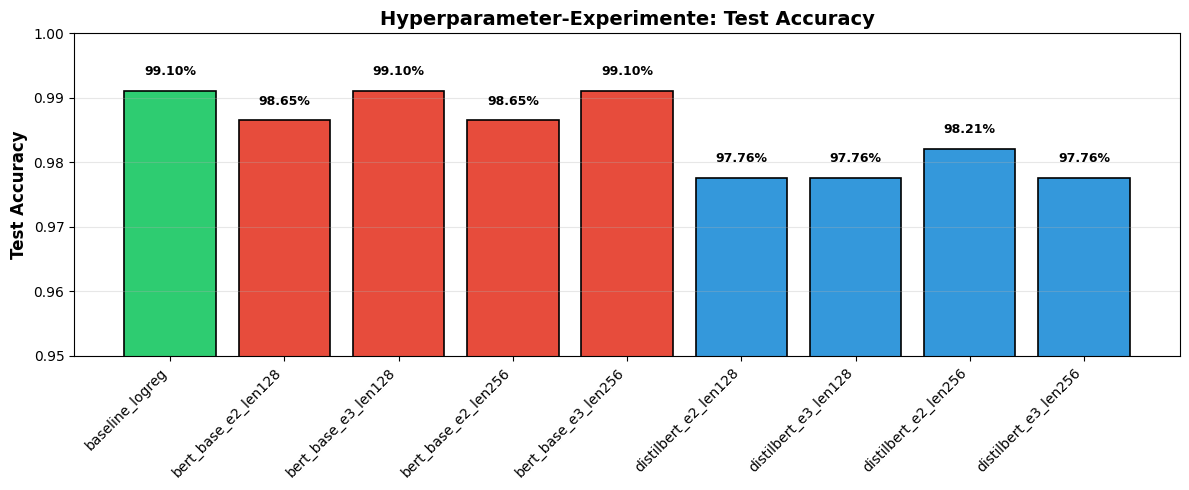

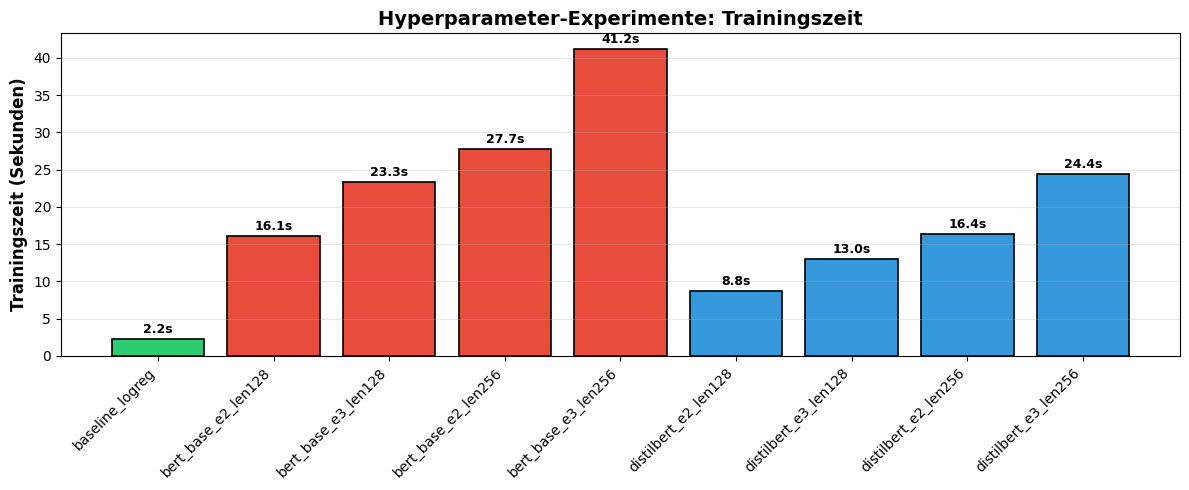

(WindowsPath('c:/CAS/cas-ml-document-classification/results/experiments_hparams/exp_accuracy.png'),
 WindowsPath('c:/CAS/cas-ml-document-classification/results/experiments_hparams/exp_train_time.png'))

In [16]:
import matplotlib.pyplot as plt

# Modell-Farben
model_colors = {
    'baseline_logreg': '#2ecc71',  # Grün
    'bert': '#e74c3c',              # Rot
    'distilbert': '#3498db'         # Blau
}

plot_df = df_runs.copy()
plot_df["short_model"] = plot_df["model"].apply(lambda x: x.split("/")[-1] if isinstance(x, str) else x)

# Farben zuweisen basierend auf Modelltyp
colors = []
for model in plot_df["model"]:
    if model == "tfidf+logreg":
        colors.append(model_colors['baseline_logreg'])
    elif "distilbert" in str(model).lower():  # DistilBERT ZUERST prüfen!
        colors.append(model_colors['distilbert'])
    elif "bert" in str(model).lower():  # Dann BERT
        colors.append(model_colors['bert'])
    else:
        colors.append('#95a5a6')  # Grau als Fallback

# Accuracy plot
plt.figure(figsize=(12,5))
bars = plt.bar(plot_df["run_name"], plot_df["test_accuracy"], color=colors, edgecolor='black', linewidth=1.2)

# Werte auf Balken anzeigen
for bar, acc in zip(bars, plot_df["test_accuracy"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{acc:.2%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylabel("Test Accuracy", fontsize=12, fontweight='bold')
plt.title("Hyperparameter-Experimente: Test Accuracy", fontsize=14, fontweight='bold')
plt.ylim(0.95, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
acc_path = EXP_DIR / "exp_accuracy.png"
plt.savefig(acc_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Time plot
plt.figure(figsize=(12,5))
bars = plt.bar(plot_df["run_name"], plot_df["train_time_sec"], color=colors, edgecolor='black', linewidth=1.2)

# Werte auf Balken anzeigen
for bar, time_val in zip(bars, plot_df["train_time_sec"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(plot_df["train_time_sec"]) * 0.01,
             f'{time_val:.1f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylabel("Trainingszeit (Sekunden)", fontsize=12, fontweight='bold')
plt.title("Hyperparameter-Experimente: Trainingszeit", fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
time_path = EXP_DIR / "exp_train_time.png"
plt.savefig(time_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

acc_path, time_path


## Kurzinterpretation

- Die Baseline (TF-IDF + Logistic Regression) erreicht auf dem BBC News Dataset sehr hohe Werte,
  was auf die klare thematische Trennung und starke Schlüsselwörter hindeutet.
- BERT erreicht ebenfalls sehr hohe Performance, benötigt jedoch deutlich mehr Rechenzeit.
- Der Vergleich von Epochen zeigt typischerweise: mehr Training hilft bis zu einem Plateau, danach kaum Gewinn.
- DistilBERT zeigt den erwarteten Trade-off: geringfügig weniger Performance bei deutlich schnellerem Training.

**Methodischer Hinweis:** Die Hyperparameter-Wahl erfolgt anhand der **Validation-Metriken**.
Die **Test-Metriken** dienen nur der finalen, unabhängigen Evaluation des gewählten Modells.
Dies verhindert Information Leakage und gewährleistet eine faire Bewertung.